In [145]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [146]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [147]:
import warnings
warnings.filterwarnings('ignore')


In [148]:
from sklearn.model_selection import train_test_split

dataset_dir = r"\Users\My PC\OneDrive\Desktop\ACL_project\ACL"


In [149]:
image_files = []
labels = []

injury_folder = os.path.join(dataset_dir, 'injury')
for filename in os.listdir(injury_folder):
    image_files.append(os.path.join(injury_folder, filename))
    labels.append(1)  # Assign label 1 for 'injury'

no_injury_folder = os.path.join(dataset_dir, 'no_injury')
for filename in os.listdir(no_injury_folder):
    image_files.append(os.path.join(no_injury_folder, filename))
    labels.append(0)  # Assign label 0 for 'no_injury'

In [150]:
df = pd.DataFrame({
    'filename': image_files,
    'label': labels
})


In [151]:
image_files[0:5]

['\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a1.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a10.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a11.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a12.jpg',
 '\\Users\\My PC\\OneDrive\\Desktop\\ACL_project\\ACL\\injury\\a13.jpg']

In [155]:
labels[0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [156]:
labels[20:-1]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Convert labels column to string


In [157]:
df['label'] = df['label'].astype(str)

In [158]:

# Split the data into training and validation sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the remaining data (train_val_df) into training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting dataframes
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (25, 2)
Validation set shape: (7, 2)
Test set shape: (8, 2)


In [159]:
df.head()


,filename,label
0,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
1,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
2,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
3,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1
4,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,1


In [160]:
df.tail()

,filename,label
35,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
36,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
37,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
38,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0
39,\Users\My PC\OneDrive\Desktop\ACL_project\ACL\...,0


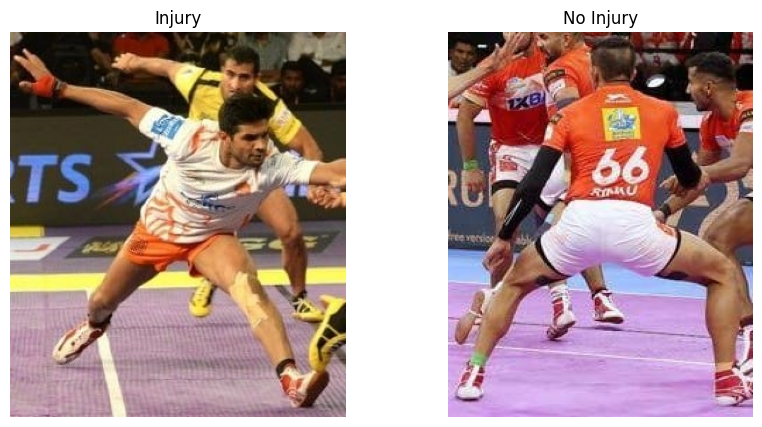

In [161]:
#import matplotlib.pyplot as plt
import cv2
import random

# Function to display one random image from each class
def display_random_images(df):
    # Get one random sample image from each class
    injury_sample = df[df['label'] == '1'].sample(n=1, random_state=random.randint(0, 1000)).iloc[0]['filename']
    no_injury_sample = df[df['label'] == '0'].sample(n=1, random_state=random.randint(0, 1000)).iloc[0]['filename']

    # Load the images using cv2
    injury_image = cv2.imread(injury_sample)
    no_injury_image = cv2.imread(no_injury_sample)

    # Convert images from BGR to RGB (OpenCV loads images in BGR format by default)
    injury_image = cv2.cvtColor(injury_image, cv2.COLOR_BGR2RGB)
    no_injury_image = cv2.cvtColor(no_injury_image, cv2.COLOR_BGR2RGB)

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display injury image
    axes[0].imshow(injury_image)
    axes[0].set_title('Injury')
    axes[0].axis('off')

    # Display no-injury image
    axes[1].imshow(no_injury_image)
    axes[1].set_title('No Injury')
    axes[1].axis('off')

    plt.show()

# Display random images from both classes
display_random_images(train_df)


Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
0 is for injury
1 is for no_injury


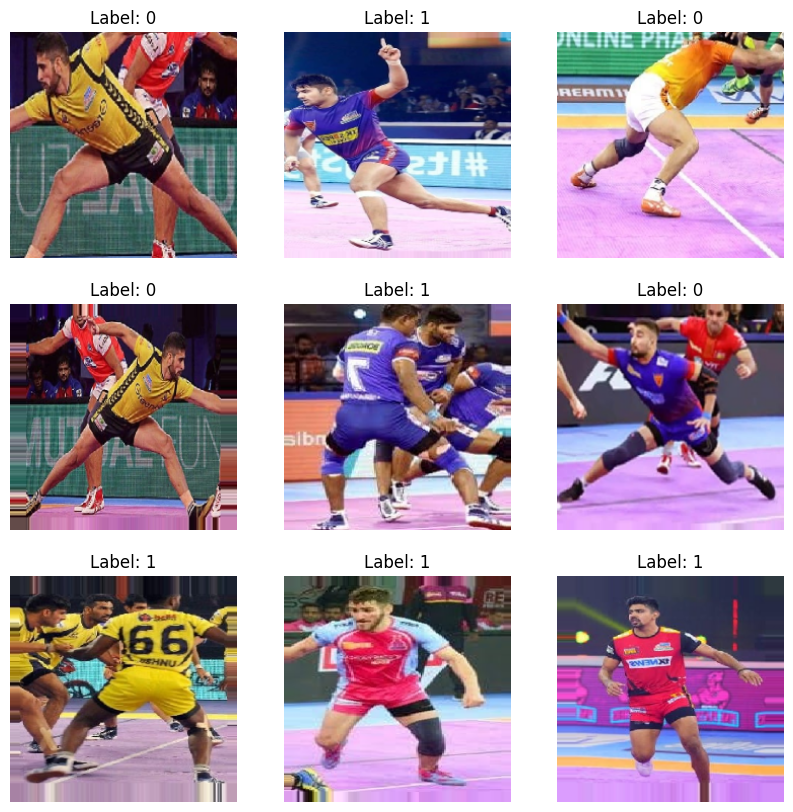

In [163]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Assuming 20% of your dataset is used for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


# Display a few augmented images
example_batch = next(train_generator)
example_images, example_labels = example_batch

print("0 is for injury")
print("1 is for no_injury")
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(example_images[i])
    plt.title(f"Label: {int(example_labels[i])}")
    plt.axis('off')
plt.show()


In [164]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the first few layers of the base model
for layer in base_model.layers[:15]:
    layer.trainable = False

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 0.6988 - val_accuracy: 0.7500 - val_loss: 0.6203
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5312 - loss: 0.6472 - val_accuracy: 1.0000 - val_loss: 0.5383
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8125 - loss: 0.5895 - val_accuracy: 0.7500 - val_loss: 0.4935
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8125 - loss: 0.5175 - val_accuracy: 1.0000 - val_loss: 0.3400
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9375 - loss: 0.4567 - val_accuracy: 1.0000 - val_loss: 0.2253
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8438 - loss: 0.4247 - val_accuracy: 0.8750 - val_loss: 0.3055
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9062 - loss: 0.3734 - val_accuracy: 1.0000 - val_loss: 0.1405
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.8750 - loss: 0.3467 - val_accuracy: 1.0000 - val_loss: 0.1026
Epoch 9/15
1/1 ━

In [165]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,452,549 (116.17 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 15,211,524 (58.03 MB)

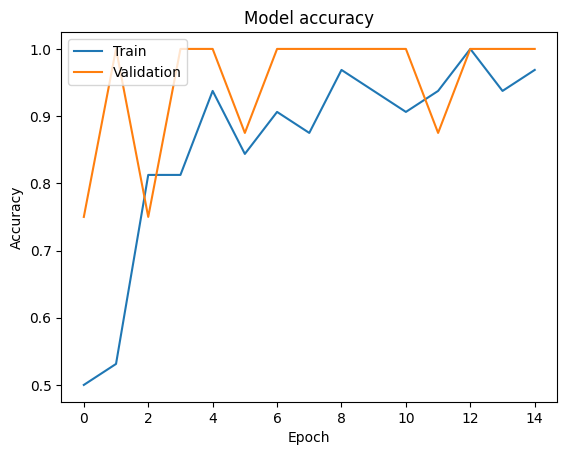

In [166]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [170]:
# Get final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


Final Training Accuracy: 0.9688
Final Validation Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


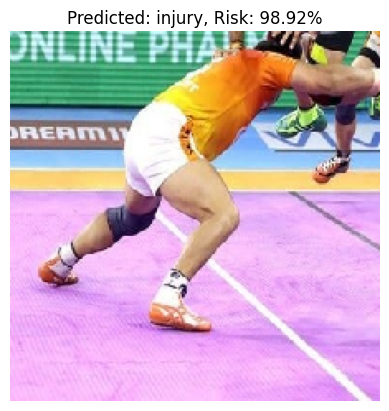

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


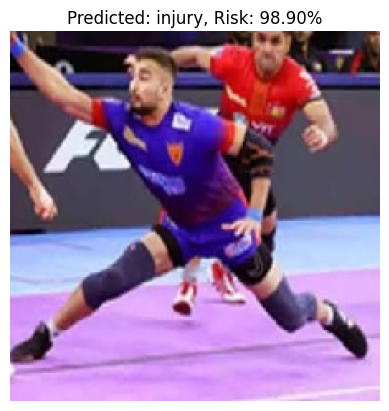

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


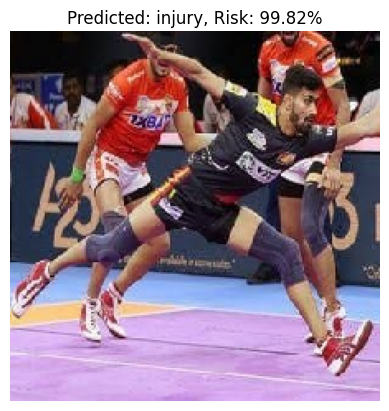

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


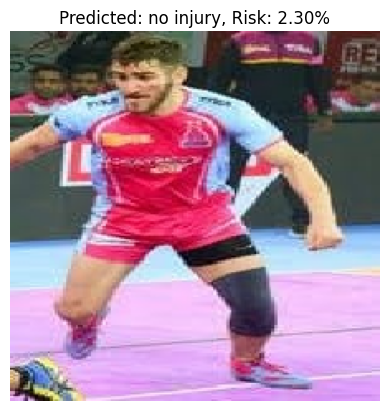

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


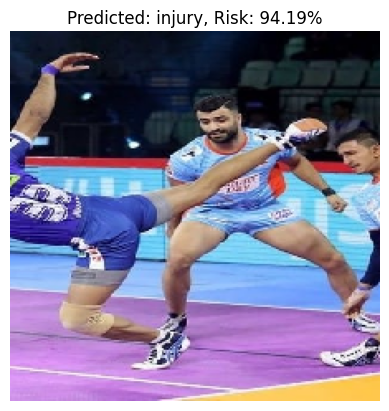

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


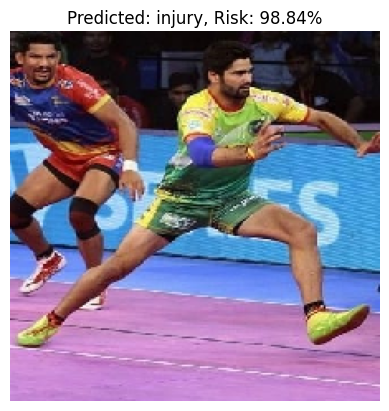

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


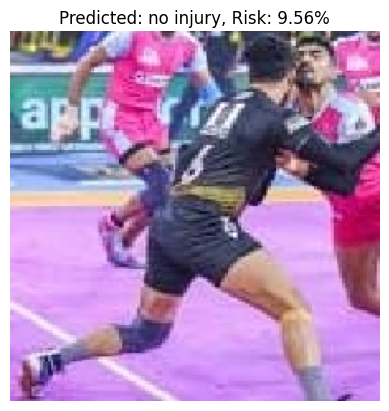

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


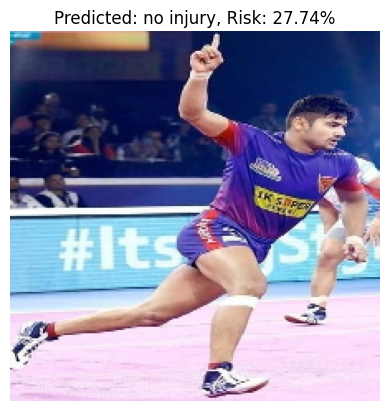

In [175]:
# Define a function to predict the class of a single image
def predict_image(model, img_path):
    """Predict the class of a single image using the trained model."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values
    prediction = model.predict(img_array)[0][0]  # Assuming binary classification output
    return prediction

# Iterate over each image in the test dataset
for index, row in test_df.iterrows():
    img_path = row['filename']
    true_label = row['label']
    predicted_prob = predict_image(model, img_path)
    predicted_label = 'injury' if predicted_prob < 0.5 else 'no injury'  # Assuming threshold of 0.5 for binary classification
    
    # Invert the probability value to reflect higher risk with higher values
    inverted_prob = 1 - predicted_prob
    
    # Convert the inverted probability to percentage
    inverted_prob_percent = inverted_prob * 100

    # Load and display the image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}, Risk: {inverted_prob_percent:.2f}%")
    plt.axis('off')
    plt.show()


In [176]:
# Save the model with .keras extension
model.save('ACL_PREDICTION.keras')
